In [1]:
from pathlib import Path
import torch
import numpy as np
import random
from data import sample_latents
from vis import visualize_latents, visualize_slots_and_output, visualize_output_grid, visualize_score_heatmaps
from models import InvertibleMLP, ParallelSlots, LinearComposition, OcclusionLinearComposition, CompositionalFunction

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [11]:
D = [2, 2]
M = [16, 16, 16]
grid_size = 11

z = sample_latents(D, "random", n_samples=10000)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

phi = ParallelSlots([InvertibleMLP(d_in, d_out, d_hidden=10) for d_in, d_out in zip(D, M)])
C = OcclusionLinearComposition(soft_add=True)
f = CompositionalFunction(C, phi).to(dev)
f.eval()
with torch.no_grad():
    x = f(z.to(dev)).to("cpu")

In [ ]:
visualize_latents(z, D, grid_size)

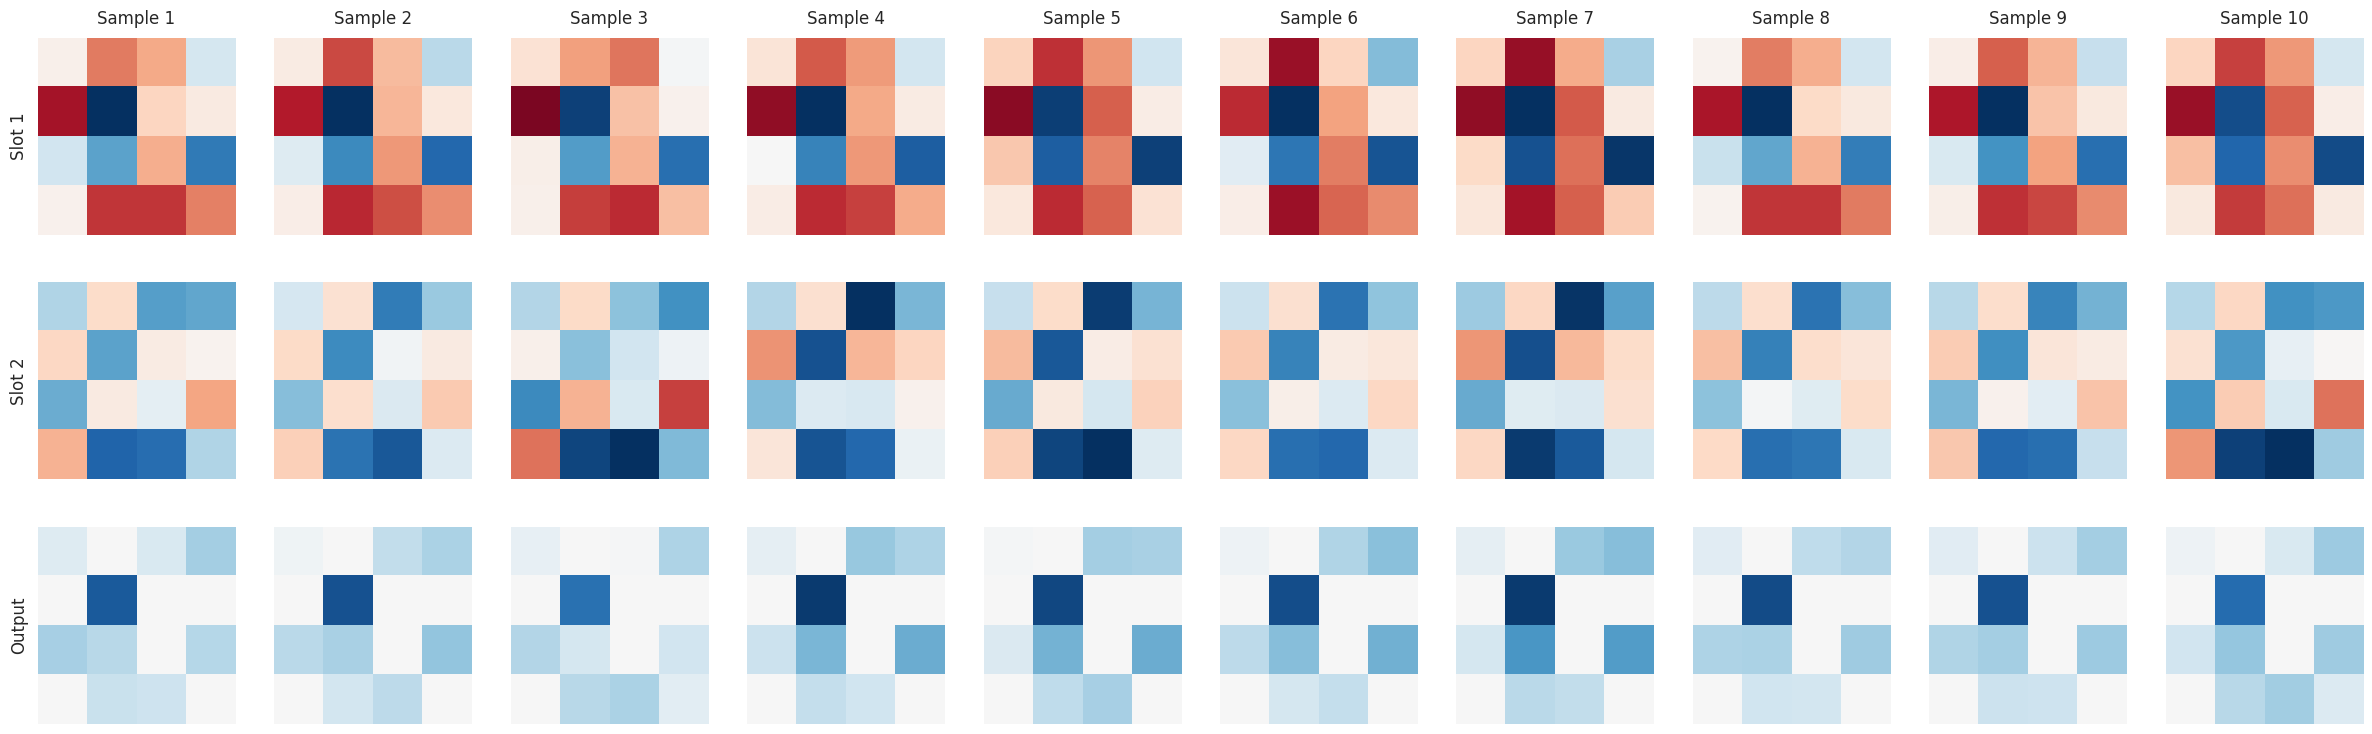

In [12]:
visualize_slots_and_output(*f.to("cpu")(z[:10], return_slot_outputs=True))

In [ ]:
visualize_output_grid(f, 5, (0, 1), plot_size=1)

In [12]:
checkpoint = Path("/home/thaddaus/code/cood/_checkpoints/ADD_ortho_20230411-140849/latest.pt")

phi_hat = ParallelSlots(
        [
            InvertibleMLP(d_in, d_out, d_hidden=10)
            for d_in, d_out in zip(D, M)
        ]
    )
f_hat = CompositionalFunction(C, phi_hat)
f_hat.to(dev)

f_hat.load_state_dict(torch.load(checkpoint))
f_hat.eval()

with torch.no_grad():
    x_hat = f_hat(z.to(dev)).to("cpu")

err = (x_hat - x).pow(2).mean(dim=-1)

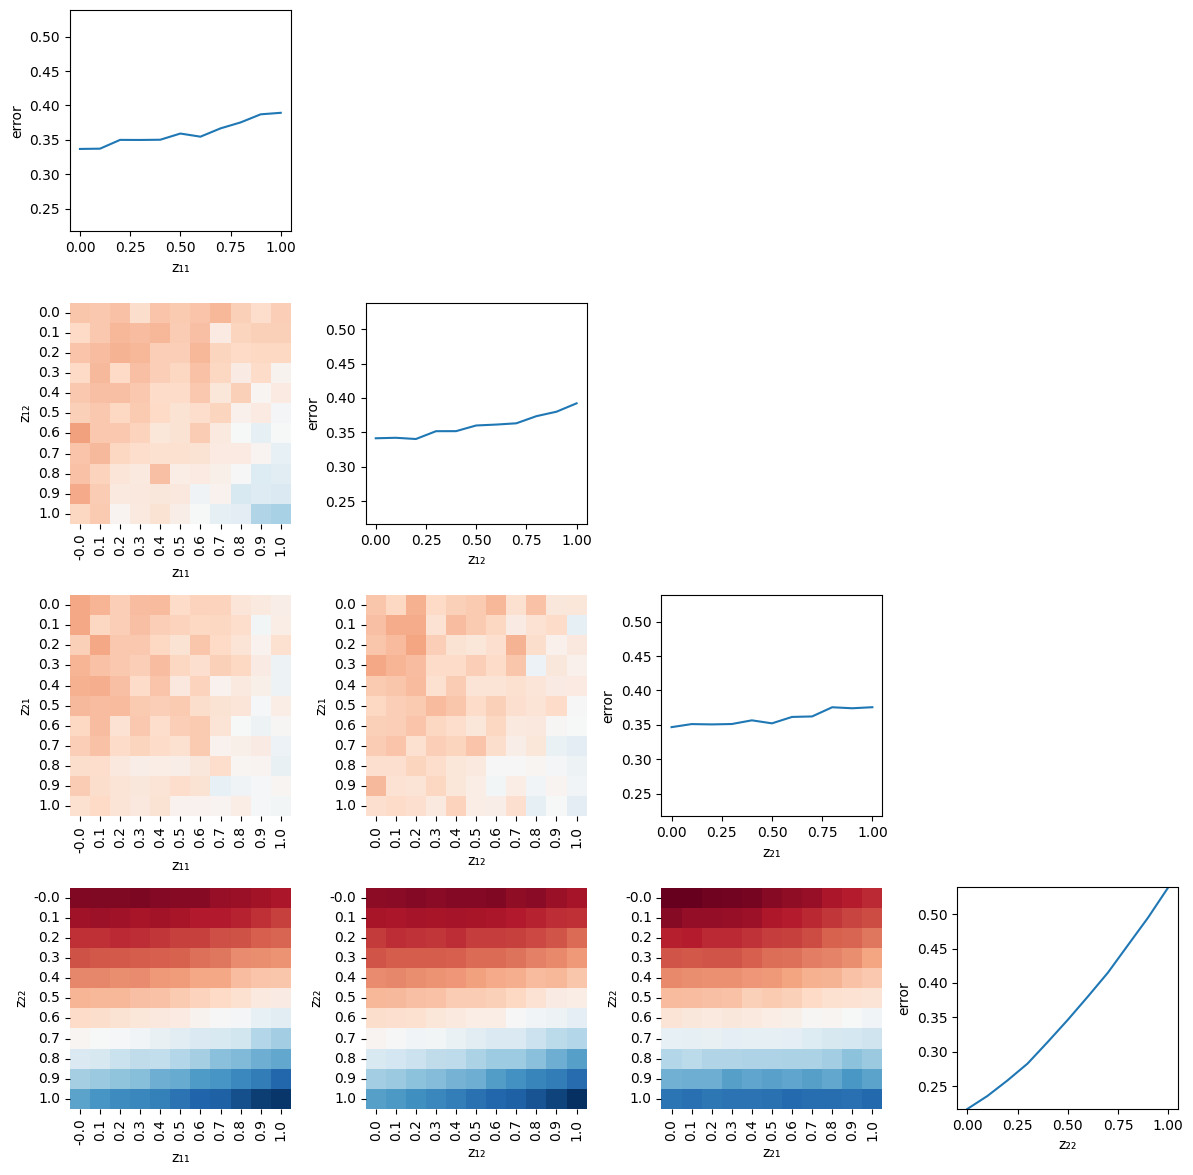

In [13]:
visualize_score_heatmaps(z, err, D, "error")